author: KeczerZs

This school project is an implemenation of Newman's (2004a) greedy modularity
maximatization algorithm and its improved version by Clauset, Newman and Moore (2004b). 

References:
Newman, M. E. (2004a). Fast algorithm for detecting community structure in networks. Physical review E, 69(6), 066133.
Clauset, A., Newman, M. E., & Moore, C. (2004b). Finding community structure in very large networks. Physical review E, 70(6), 066111.

The code of greedyQ function is also based on networkx library codes by Edward L. Platt
Reference: 
https://networkx.github.io/documentation/latest/_modules/networkx/algorithms/community/modularity_max.html 

In [1]:
# Dependecies for the the algorithms below
import networkx as nx
from networkx.algorithms import community

In [2]:
def greedyQ(graph):
    '''
    Current version (simplified version of codes by Edward L. Platt):
    -Only for undirected and unweighted networks    
    -For node labels that are consecutive integers from 0 to N-1 in the input graph
     where N is the number of nodes
     Example for node labels in the input (undirected, unweighted graph with 7 nodes):
     > graph.nodes()
     > NodeView((0, 1, 2, 3, 4, 5, 6))
     
    This function uses networx library.
    > import networkx
    > from networkx.algorithms import community
    
    graph : networkx graph object (undirected and unweighted, node labes from 0 to N-1)
        
    TODO
    -Solve arbitrary node labels
    -Solve weighted graph
    -Solve best output format
    -Solve implemention with a heap
        
    #Returns communityMerges : list of about all merges
    Returns communities : list of forzen sets, communities at the maximum Q value
    
    '''
    
    # Constants (capitalized): graph data
    # N: number of nodes
    N = len(graph.nodes()) 
    # M: number of edges
    M = len(graph.edges()) 
    # DEGREES: list of ints, degrees of nodes in order
    DEGREES = [graph.degree()[i] for i in range(N)] 
    
    # Initialize community and merge lists
    # commintiy merging (alway i into j) happens with set joining operation
    communities = {i : frozenset([i]) for i in range(N)}
    # keeping track of community merges, elements: (i, j, deltaQ_ij, Q)
    communityMerges = []
    
    # Initial modularity value (Q)
    # each node is considered as a community
    partition = [list(c) for c in communities.values()]
    # calculatin Q using networkx.algorithms.community namespace
    Q = community.modularity(graph, partition)
    
    # Initial data for while loop   
    # half of the fraction of edges btw communities i and j (each community has one node at first)
    # (variable name Eij is from the Clauset, Newman and Moore article)
    Eij = 1.0 / (2.0*M) 
    # fraction of half-edges in each community
    # (variable name a is from the Clauset, Newman and Moore article)
    a = [DEGREES[i] / (2.0*M) for i in range(N)]   
    # nested dictionary represenation of matrix cells where there are edges in the orginial adjecency matrix
    # outer key i represents row index, inner key j represents coloumn index
    deltaQ = {i: 
                {j: 2*Eij - 2*DEGREES[i]*DEGREES[j]*Eij**2 
                 for j in graph.neighbors(i) if j!= i
                } 
              for i in range(N)
             }    
    
    # we remove keys (representig matrix rows) from deltaQ in each iteraton, 
    # we can iterate until all nodes are in one community (one key remains in deltaQ)
    #
    # alternatively: we can iterate till the Q value increases, then break from the loop
    # this assumes that there is a single highest peek of the Q value in the process
    # (see the Clauset, Newman and Moore article)
    while len(deltaQ) > 1:
        
        # Select maximum deltaQ value and its coordinates (i and j)
        # For this, a heap was used in the orginial article, which yields better speed performance
        # i : j of max deltaQ (row maximum coordinate)
        maxDeltaQ_j_dict = {i : max(j.keys(), key=(lambda x: j[x])) for i,j in zip(deltaQ, deltaQ.values())} 
         # i : row max deltaQ value (row maximum value)
        maxDeltaQ_i_dict = {i : deltaQ[i][maxDeltaQ_j_dict[i]] for i in deltaQ}  
        # i coordinate (the highest of the row maximum deltaQ values)
        maxDeltaQ_i = max(maxDeltaQ_i_dict.keys(), key=(lambda x: maxDeltaQ_i_dict[x])) 
        # j coordinate (the row maximum coordinate in the row i)
        maxDeltaQ_j = maxDeltaQ_j_dict[maxDeltaQ_i] 
        # maximum deltaQ value (at the i and j coordinates)
        maxDeltaQ_value =  deltaQ[maxDeltaQ_i][maxDeltaQ_j] 
        
        # Increment Q by the maximum delta Q value
        Q += maxDeltaQ_value

        # Breaking out of the loop if Q value does not increase
        if len(communityMerges) > 0 and Q <= communityMerges[-1][-1]:
            break          
        
        # Merge communities (i and j) yielding maximum deltaQ:
        i,j = maxDeltaQ_i,maxDeltaQ_j
        communities[j] = frozenset(communities[i] | communities[j])
        del communities[i]
        communityMerges.append((i, j, maxDeltaQ_value, Q))        
        
        
        # Find values to update in detlaQ (for communities connected to communities i and j)
        neighbors_i = set(deltaQ[i].keys())
        neighbors_j = set(deltaQ[j].keys())
        allNeighbors_ij = (neighbors_i | neighbors_j) - set([i, j])
        commonNeighbors_ij = neighbors_i & neighbors_j
        
        # Merge community i into j
        # (variable name k is from the Clauset, Newman and Moore article)
        for k in allNeighbors_ij:
            # calculate new deltaQ value
            if k in commonNeighbors_ij:
                deltaQ_jk = deltaQ[j][k] + deltaQ[i][k]
            elif k in neighbors_j:
                deltaQ_jk = deltaQ[j][k] - 2.0*a[i]*a[k]
            else: # k in neighbors_i
                deltaQ_jk = deltaQ[i][k] - 2.0*a[j]*a[k]          
            # Update dictionary DeltaQ I.: for rows j and k (i is removed below) 
            deltaQ[j][k] = deltaQ_jk
            deltaQ[k][j] = deltaQ_jk 
        # end of for                
        
        # Update the dictionary DeltaQ II.: row i is removed here
        # remove row and column i
        for k in neighbors_i:
            # remove i from coloumns
            del deltaQ[k][i]  
        # remove row i
        del deltaQ[i] 
        
        # Update list elements a[j] and a[i]
        a[j] += a[i]
        a[i] = 0 
               
    #end of while 
    
    # Returning data about community merges (e.g., for createing dendogram)
    #return communityMerges
    
    # Returning partion at maximum Q value
    communities = [frozenset(c) for c in communities.values()]
    return sorted(communities, key=len, reverse=True)

In [3]:
def createTestGraph1():
    '''
    Creates a simple, undirected and unweighted test graph with 7 nodes.
    
    The test graph G has two fully-connected clusters and there is
    a single-node bridge between the clusters.
    
    This function uses networx library.
    > import networkx
    
    Example:
    > G = createTestGraph1()
    > nx.draw(G)
    > G.nodes()
    > NodeView((0, 1, 2, 3, 4, 5, 6))
    > print(community.modularity(G, [[0, 1, 2], [3, 4, 5, 6]]))
    > 0.35499999999999987
    
    returns G : networkx graph object
    '''
    G = nx.Graph()

    #cluster 1 : 0,1,2
    G.add_edge(0,1)
    G.add_edge(0,2)
    G.add_edge(1,2)
    
    #bridge
    G.add_edge(2,3)
    
    #cluster 2 : 3,4,5,6
    G.add_edge(3,4)
    G.add_edge(3,5)
    G.add_edge(3,6)
    G.add_edge(4,5)
    G.add_edge(4,6)
    G.add_edge(5,6)
    
    return G

[frozenset({3, 4, 5, 6}), frozenset({0, 1, 2})]


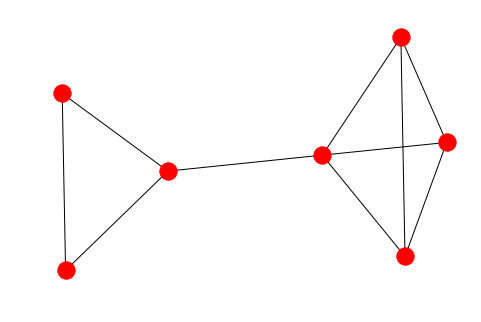

In [4]:
# a simple test code

# create the test graph: undirected and unweighted test graph with 7 nodes
G = createTestGraph1()

%matplotlib inline
nx.draw(G)

# run the greedyQ function to find the best partition
bestPartition = greedyQ(G)
print(bestPartition)